In [1]:
import sys
import os

import numpy as np

import scipy.io
from matplotlib import pyplot as plt

import matplotlib

import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm


font = {'family' : 'Sans',
        'weight' : 'regular',
        'size'   : 18}

matplotlib.rc('font', **font)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same"),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.AvgPool2d(kernel_size=(2,2))

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up   = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [2]:
class u_net(nn.Module):
    def __init__(self, in_channels, feat):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels,   feat)
        self.down_convolution_2 = DownSample(    feat,  2 * feat)
        self.down_convolution_3 = DownSample(2 * feat,  4 * feat)
        self.down_convolution_4 = DownSample(4 * feat,  8 * feat)

        self.bottle_neck        = DoubleConv(8 * feat, 16 * feat)

        self.up_convolution_1 = UpSample(16 * feat + 8 * feat,  8 * feat)
        self.up_convolution_2 = UpSample(8  * feat + 4 * feat,  4 * feat)
        self.up_convolution_3 = UpSample(4  * feat + 2 * feat,  2 * feat)
        self.up_convolution_4 = UpSample(2  * feat +     feat,      feat)

        # Sigmoid to convert the numerics
        self.out = nn.Conv2d(in_channels=feat, out_channels=1, kernel_size=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
       
        return self.sig(out)

In [3]:
# Path to the folder containing .mat files

ANGLE = "120" # "120", "100", "80"

x_folder_path = 'train/XImages'+ANGLE
y_folder_path = 'train/YImages'

# List all .mat files in the folder
x_mat_files = sorted([f for f in os.listdir(x_folder_path) if f.endswith('.mat')])
y_mat_files = sorted([f for f in os.listdir(y_folder_path) if f.endswith('.mat')])

x_train_list = []  # list of artifact images with missing angle (180 - ANGLE)
y_train_list = []  # list of true images
sample_size = 10000
for i in range(sample_size):
    x_mat = scipy.io.loadmat(os.path.join(x_folder_path, x_mat_files[i]))
#     print(x_mat)
    x_train = x_mat['P']
    x_train_list.append(x_train)
    
    y_mat = scipy.io.loadmat(os.path.join(y_folder_path, y_mat_files[i]))
    y_train = y_mat['im_reduced']
    y_train_list.append(y_train)

x_train_full = np.array(x_train_list)
y_train_full = np.array(y_train_list)

In [4]:
# training data

xdata = x_train_full[:5000]
ydata = y_train_full[:5000]

test_xdata = x_train_full[5000::]
test_ydata = y_train_full[5000::]

In [5]:
from torch.utils.data.dataset import Dataset

class CT_Dataset(Dataset):
    def __init__(self, xdata, ydata):
        self.xdata = torch.tensor(xdata).unsqueeze(dim=1)
        self.ydata = torch.tensor(ydata).unsqueeze(dim=1)
        
    def __getitem__(self, index):
        x_img = self.xdata[index]
        y_img = self.ydata[index]

        return x_img, y_img

    def __len__(self):
        return len(self.xdata)

In [6]:
BATCH_SIZE = 50

train_dataset = CT_Dataset(xdata, ydata)
test_dataset = CT_Dataset(test_xdata, test_ydata)

generator = torch.Generator().manual_seed(0)

train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

In [7]:
LEARNING_RATE = 1e-4

EPOCHS = 75

MODEL_SAVE_PATH = "./models/model_unet_" + ANGLE +".pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = u_net(in_channels=1, feat=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.MSELoss()

In [9]:
import time

history = {'train_loss': [], 'val_loss': []}
best_val_loss = None

for epoch in range(EPOCHS):
    tic = time.time()
    model.train()
    train_running_loss = 0
    for idx, xydata in enumerate((train_dataloader)):
        _xdata = xydata[0].float().to(device)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata)
        optimizer.zero_grad()

        loss = criterion(y_pred, _ydata)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    
    scheduler.step()
    
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, xydata in enumerate(val_dataloader):
            _xdata = xydata[0].float().to(device)
            _ydata = xydata[1].float().to(device)

            y_pred = model(_xdata)
            loss = criterion(y_pred, _ydata)

            val_running_loss += loss.item()
        val_loss = val_running_loss / (idx + 1)

    elapse = time.time() - tic

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    if best_val_loss is None or val_loss < best_val_loss:
        torch.save(model.state_dict(), MODEL_SAVE_PATH) # official recommended
        best_val_loss = val_loss
    
    print(f"Train Loss EPOCH {(epoch+1):6d}: {train_loss:6.4e} | Valid Loss EPOCH {(epoch+1):6d}: {val_loss:6.4e} | time: {elapse: 6.4f}")

Train Loss EPOCH      1: 1.2714e-01 | Valid Loss EPOCH      1: 7.1898e-02 | time:  8.4333
Train Loss EPOCH      2: 8.2682e-02 | Valid Loss EPOCH      2: 5.9957e-02 | time:  8.1429
Train Loss EPOCH      3: 6.6310e-02 | Valid Loss EPOCH      3: 5.4344e-02 | time:  8.1767
Train Loss EPOCH      4: 5.7234e-02 | Valid Loss EPOCH      4: 4.9626e-02 | time:  8.1923
Train Loss EPOCH      5: 4.9545e-02 | Valid Loss EPOCH      5: 4.0948e-02 | time:  8.2186
Train Loss EPOCH      6: 4.3690e-02 | Valid Loss EPOCH      6: 3.5545e-02 | time:  8.2238
Train Loss EPOCH      7: 3.9350e-02 | Valid Loss EPOCH      7: 3.5254e-02 | time:  8.2415
Train Loss EPOCH      8: 3.5823e-02 | Valid Loss EPOCH      8: 3.2018e-02 | time:  8.2495
Train Loss EPOCH      9: 3.2738e-02 | Valid Loss EPOCH      9: 3.1569e-02 | time:  8.2523
Train Loss EPOCH     10: 2.9926e-02 | Valid Loss EPOCH     10: 2.5395e-02 | time:  8.2793
Train Loss EPOCH     11: 2.7586e-02 | Valid Loss EPOCH     11: 2.4577e-02 | time:  8.2696
Train Loss

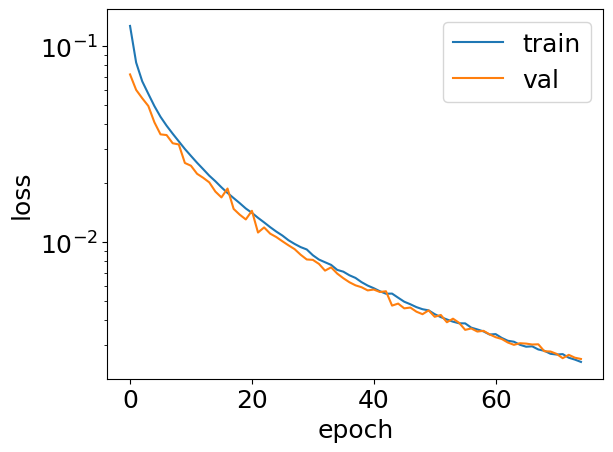

In [10]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log',base=10) 
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [11]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH), strict=True)
model.eval()

test_running_loss = 0

with torch.no_grad():

    for idx, xydata in enumerate(test_dataloader):
        _xdata = xydata[0].float().to(device)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata)
        loss = criterion(y_pred, _ydata)

        test_running_loss += loss.item()
        test_loss = test_running_loss / (idx + 1)

    print(test_loss)

0.002527281150687486
